<a href="https://colab.research.google.com/github/junia3/Faster-Deep-Hedging/blob/main/DeepHedging_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Asian option Delta Hedging jupyter Implementation

@copyright Junyoung Park

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Define current device (cpu or cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Calculate Black scholes premium

In [ ]:
# Black scholes call option premium and put option premium
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+(sig**2)/6)*(T/2))/(sig*np.sqrt(T/3))
    d2 = (np.log(S/K)+(r-(sig**2)/2)*(T/2))/(sig*np.sqrt(T/3))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+(sig**2)/6)*(T/2))/(sig*np.sqrt(T/3))
    d2 = (np.log(S/K)+(r-(sig**2)/2)*(T/2))/(sig*np.sqrt(T/3))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

## Function that train model for one epoch with training dataset

In [ ]:
def train_with_dataloader(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        model.train()
        S, S_mean, S_diff, premium, K = data
        S_diff = S_diff.to(device)
        premium = premium.to(device)
        geo_call = torch.maximum(S_mean-K, torch.zeros_like(S_mean)).to(device)

        optimizer.zero_grad()
        delta = model(S_diff)
        costs = torch.sum(delta.mul(S_diff), 1)

        loss = criterion(costs+geo_call, premium)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    return running_loss/len(dataloader)

## Function that evaluates trained model with validation dataset

In [ ]:
'''
def evaluate_with_dataloader(model, dataloader):
    model.eval()
    prices, results = [], []
    with torch.no_grad():
            for i, data in enumerate(dataloader):
                S, S_mean, S_diff, premium, K = data
                S_diff = S_diff.to(device)
                premium = premium.to(device)
                geo_call = torch.maximum(S_mean-K, torch.zeros_like(S_mean)).to(device)

                delta = model(S_diff)
                costs = torch.sum(delta.mul(S_diff), 1)
                results += list((costs + geo_call-premium).cpu().numpy())
                prices += list(S[:, -1].cpu().numpy())
            
            plt.scatter(prices, results, color='black', s=2)
            plt.ylim([-2, 2])
            plt.savefig(f'slp_{str(K_val)}_dist.png')
            plt.show()
            plt.hist(results, color='black')
            plt.xlim([-6, 6])
            plt.savefig(f'slp_{str(K_val)}_hist.png')
            plt.show()
    
    return np.array(results)
'''

## Entropic loss

In [ ]:
def entropic_loss(pnl):
    pnl = torch.Tensor(pnl)
    return -torch.mean(-torch.exp(-pnl)).numpy()

In [ ]:
result = pd.DataFrame() 
def evaluate_model(Y):
    Y = pd.Series(Y)
    metric = {
        "Entropic Loss Measure (ERM)" : entropic_loss(Y)
    }
    return metric

## Define asset price dataset

In [ ]:
class PriceDataset(Dataset):
    def __init__(self, samples, args, price_option=None, strike_option=None):
        r, sig, T, N = args
        self.samples = samples
        dt = T/N
        rdt = r*dt
        sigsdt = sig * np.sqrt(dt)

        self.S = np.empty([self.samples,N+1])
        self.S_mean = np.empty([self.samples])
        self.S_diff = np.empty([self.samples, N])
        self.premium = np.empty([self.samples])
        self.K = np.empty([self.samples])
        self.price_option = price_option

        rv = np.random.normal(r*dt,sigsdt,[self.samples,N])

        for i in range(self.samples):
            if price_option is None:
                self.S[i,0] = np.random.uniform(90, 110)
            else:
                self.S[i,0] = price_option

            for j in range(N):
                self.S[i,j+1] = self.S[i,j] * (1+rv[i,j])
                self.S_diff[i, j] = self.S[i, j+1]-self.S[i, j]

        for i in range(self.samples):
            self.S_mean[i] = np.exp(np.mean(np.log(self.S[i, :])))
            if strike_option is None:
                self.K[i] = np.random.uniform(90, 110)
                self.premium[i] = bscall(self.S[i, 0], self.K[i], T, r, sig)
            else:
                self.K[i] = strike_option
                self.premium[i] = bscall(self.S[i, 0], strike_option, T, r, sig)

    def __len__(self):
        return self.samples
  
    def __getitem__(self, idx):
        S = self.S[idx, :]
        mean = self.S_mean[idx]
        diff = self.S_diff[idx, :]
        premium = self.premium[idx]
        k = self.K[idx]

        return torch.from_numpy(S).float(), mean, torch.from_numpy(diff).float(), premium, k

## SLP network

In [ ]:
class DeltaNet(nn.Module):
    def __init__(self, price_length):
        super(DeltaNet, self).__init__()
        self.layer1 = nn.Linear(price_length, price_length*2)
        self.layer2 = nn.Linear(price_length*2, price_length*4)
        self.layer3 = nn.Linear(price_length*4, price_length*2)
        self.layer4 = nn.Linear(2*price_length, price_length)

    def forward(self, x):
        delta = F.leaky_relu(self.layer1(x), 0.01, inplace=True)
        delta = F.leaky_relu(self.layer2(delta), 0.2, inplace=True)
        delta = F.leaky_relu(self.layer3(delta), 0.2, inplace=True)
        delta = torch.tanh(self.layer4(delta))

        return delta

## Create train / validation dataset and dataloader

In [ ]:
# r, sig, T, N = args
r = 0.02
sig = 0.2
T = 100/365
N = 500
K_val = 100

# Can change args when generating dataset
args = [r, sig, T, N]

p_dataset = PriceDataset(50000, args, 100, K_val)
v_dataset = PriceDataset(5000, args, 100, K_val)
train_dataloader = DataLoader(p_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(v_dataset, batch_size=256, shuffle=False)

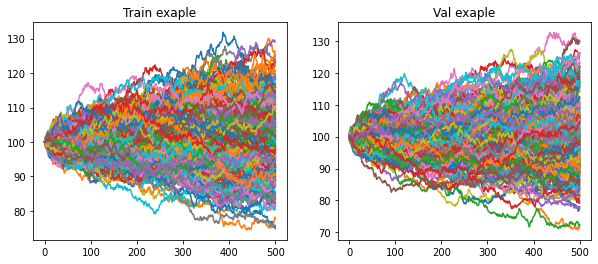

In [ ]:
train_data_example = iter(train_dataloader)
val_data_example = iter(val_dataloader)

train_batch = train_data_example.next()
val_batch = val_data_example.next()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for sample in range(len(train_batch[0])):
    plt.plot(train_batch[0].numpy()[sample, :])
plt.title('Train exaple')
plt.subplot(1, 2, 2)
for sample in range(len(val_batch[0])):
    plt.plot(val_batch[0].numpy()[sample, :])
plt.title('Val exaple')
plt.show()

## Train Simple MLP(SLP)

In [ ]:
def evaluate_with_dataloader(model, dataloader):
    model.eval()
    prices, results = [], []
    with torch.no_grad():
            for i, data in enumerate(dataloader):
                S, S_mean, S_diff, premium, K = data
                S_diff = S_diff.to(device)
                premium = premium.to(device)
                geo_call = torch.maximum(S_mean-K, torch.zeros_like(S_mean)).to(device)

                delta = model(S_diff)
                costs = torch.sum(delta.mul(S_diff), 1)
                results += list((costs + geo_call-premium).cpu().numpy())
                prices += list(S[:, -1].cpu().numpy())
            
            plt.scatter(prices, results, color='black', s=2)
            plt.ylim([-2, 2])
            plt.savefig(f'slp_{str(K_val)}_dist.png')
            plt.show()
            plt.hist(results, color='black')
            plt.xlim([-6, 6])
            plt.savefig(f'slp_{str(K_val)}_hist.png')
            plt.show()
    
    return np.array(results)

[epoch : 1] ===========> training loss: 0.943997
[epoch : 11] ===========> training loss: 0.345743
[epoch : 21] ===========> training loss: 0.177093
[epoch : 31] ===========> training loss: 0.095693
[epoch : 41] ===========> training loss: 0.050173
[epoch : 51] ===========> training loss: 0.026005
[epoch : 61] ===========> training loss: 0.013058
[epoch : 71] ===========> training loss: 0.006577
[epoch : 81] ===========> training loss: 0.003313
[epoch : 91] ===========> training loss: 0.001656
[epoch : 101] ===========> training loss: 0.000868
[epoch : 111] ===========> training loss: 0.000471
[epoch : 121] ===========> training loss: 0.000285
[epoch : 131] ===========> training loss: 0.000196
[epoch : 141] ===========> training loss: 0.000154
[epoch : 151] ===========> training loss: 0.000134
[epoch : 161] ===========> training loss: 0.000124
[epoch : 171] ===========> training loss: 0.000117
[epoch : 181] ===========> training loss: 0.000112
[epoch : 191] ===========> training loss: 

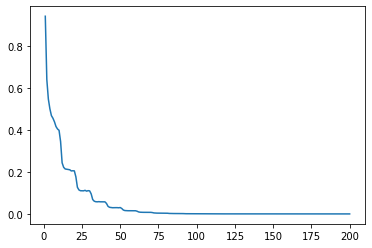

In [ ]:
model = DeltaNet(N).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5, verbose=False)
criterion = nn.L1Loss()
epochs=200
loss_hist_delta=[]
for epoch in range(epochs):
    current_loss = train_with_dataloader(model, train_dataloader, optimizer, criterion)
    loss_hist_delta.append(current_loss)
    if epoch%10 == 0:
        print('[epoch : %d] ===========> training loss: %.6f' %(epoch+1, current_loss))
    scheduler.step()

plt.plot(np.arange(1, epochs+1), loss_hist_delta)

## Validate model with validation dataset(Distribution and Histogram)

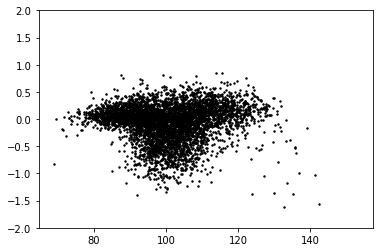

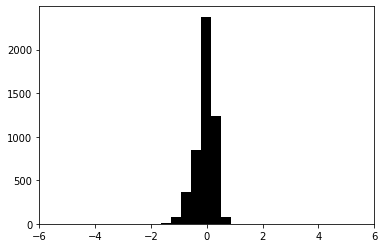

In [ ]:
eval_result = evaluate_model(evaluate_with_dataloader(model, val_dataloader))
df = pd.DataFrame(eval_result, index=[f'SLP: {str(K_val)}'])
result = pd.concat([result,df])

In [ ]:
print(result)

           Entropic Loss Measure (ERM)
SLP: 90                       1.016210
SCNN: 90                      1.055669
SLP: 100                      1.150559
SCNN: 100                     3.553056
SLP: 110                      1.006929
SCNN: 110                     1.066023
SLP: 100                      1.126617
SCNN: 100                     1.386082
SLP: 100                      1.136333


## SCNN Network

In [ ]:
class ConvDeltaNet(nn.Module):
    def __init__(self, price_length):
        super(ConvDeltaNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1)

        self.classifier = nn.Sequential(
            nn.Linear(32*price_length, 4*price_length),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(4*price_length, price_length),
        )
        
    def forward(self, x):
        delta = x.unsqueeze(1)
        delta = F.relu(self.conv1(delta), inplace=True)
        delta = F.relu(self.conv2(delta), inplace=True)
        delta = F.relu(self.conv3(delta), inplace=True)

        delta = delta.view(delta.size()[0], -1)
        delta = torch.tanh(self.classifier(delta))
        return delta

[epoch : 1] ===========> training loss: 1.051793
[epoch : 11] ===========> training loss: 0.221829
[epoch : 21] ===========> training loss: 0.120753
[epoch : 31] ===========> training loss: 0.065329
[epoch : 41] ===========> training loss: 0.033767
[epoch : 51] ===========> training loss: 0.016702
[epoch : 61] ===========> training loss: 0.008605
[epoch : 71] ===========> training loss: 0.004156
[epoch : 81] ===========> training loss: 0.002142
[epoch : 91] ===========> training loss: 0.001069
[epoch : 101] ===========> training loss: 0.000546
[epoch : 111] ===========> training loss: 0.000277
[epoch : 121] ===========> training loss: 0.000152
[epoch : 131] ===========> training loss: 0.000088
[epoch : 141] ===========> training loss: 0.000055
[epoch : 151] ===========> training loss: 0.000037
[epoch : 161] ===========> training loss: 0.000027
[epoch : 171] ===========> training loss: 0.000022
[epoch : 181] ===========> training loss: 0.000018
[epoch : 191] ===========> training loss: 

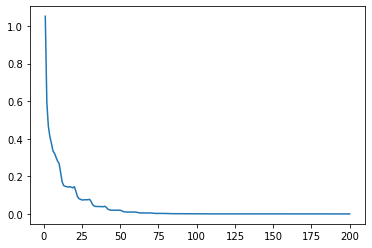

In [ ]:
model_conv = ConvDeltaNet(N).to(device)
optimizer = torch.optim.Adam(model_conv.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5, verbose=False)
criterion = nn.L1Loss()
epochs=200
loss_hist_delta=[]
for epoch in range(epochs):
    current_loss = train_with_dataloader(model_conv, train_dataloader, optimizer, criterion)
    loss_hist_delta.append(current_loss)
    if epoch%10 == 0:
        print('[epoch : %d] ===========> training loss: %.6f' %(epoch+1, current_loss))
    scheduler.step()

plt.plot(np.arange(1, epochs+1), loss_hist_delta)

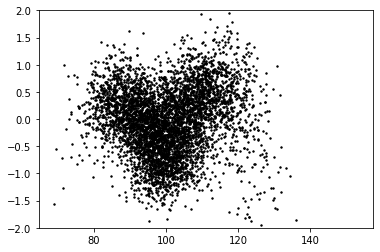

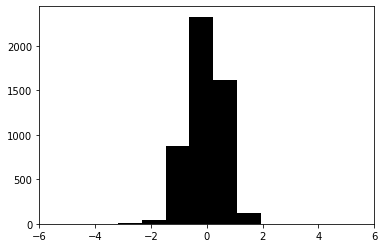

           Entropic Loss Measure (ERM)
SLP: 90                       1.016210
SCNN: 90                      1.055669
SLP: 100                      1.150559
SCNN: 100                     3.553056
SLP: 110                      1.006929
SCNN: 110                     1.066023
SLP: 100                      1.126617
SCNN: 100                     1.386082
SLP: 100                      1.136333
SCNN: 100                     1.575617


In [ ]:
def evaluate_with_dataloader(model, dataloader):
    model.eval()
    prices, results = [], []
    with torch.no_grad():
            for i, data in enumerate(dataloader):
                S, S_mean, S_diff, premium, K = data
                S_diff = S_diff.to(device)
                premium = premium.to(device)
                geo_call = torch.maximum(S_mean-K, torch.zeros_like(S_mean)).to(device)

                delta = model(S_diff)
                costs = torch.sum(delta.mul(S_diff), 1)
                results += list((costs + geo_call-premium).cpu().numpy())
                prices += list(S[:, -1].cpu().numpy())
            
            plt.scatter(prices, results, color='black', s=2)
            plt.ylim([-2, 2])
            plt.savefig(f'scnn_{str(K_val)}_dist.png')
            plt.show()
            plt.hist(results, color='black')
            plt.xlim([-6, 6])
            plt.savefig(f'scnn_{str(K_val)}_hist.png')
            plt.show()
    
    return np.array(results)

eval_result = evaluate_model(evaluate_with_dataloader(model_conv, val_dataloader))
df = pd.DataFrame(eval_result, index=[f'SCNN: {str(K_val)}'])
result = pd.concat([result, df])
print(result)

## Compare distribution and histrogram from two different models

In [ ]:
def compare_with_dataloader(model1, model2, dataloader):
    model1.eval()
    model2.eval()
    prices1, results1 = [], []
    prices2, results2 = [], []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            S, S_mean, S_diff, premium, K = data
            S_diff = S_diff.to(device)
            premium = premium.to(device)
            geo_call = torch.maximum(S_mean-K, torch.zeros_like(S_mean)).to(device)
            delta1 = model1(S_diff)
            delta2 = model2(S_diff)

            costs1 = torch.sum(delta1.mul(S_diff), 1)
            costs2 = torch.sum(delta2.mul(S_diff), 1)
            
            results1 += list((costs1 + geo_call-premium).cpu().numpy())
            prices1 += list(S[:, -1].cpu().numpy())

            results2 += list((costs2 + geo_call-premium).cpu().numpy())
            prices2 += list(S[:, -1].cpu().numpy())
            
        plt.scatter(prices1, results1, color='darkred', s=2)
        plt.scatter(prices2, results2, color='darkblue', s=2)
        plt.ylim([-2, 2])
        plt.savefig(f'compare_{str(K_val)}_dist.png')
        plt.show()

        plt.hist([results1, results2], color=['darkred', 'darkblue'])
        plt.xlim([-6, 6])
        plt.savefig(f'compare_{str(K_val)}_hist.png')
        plt.show()

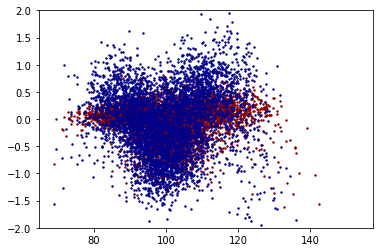

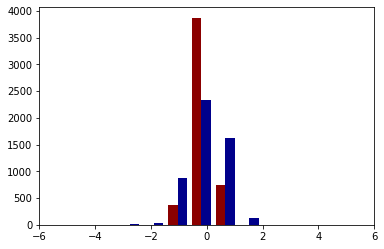

In [ ]:
compare_with_dataloader(model, model_conv, val_dataloader)

## Measure ERM(Entropic Loss Measure)